In [99]:
from kafka import KafkaConsumer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle


In [100]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [101]:
for m in consumer:
        m.value
        break

In [102]:
def read1000(number):
    records=[]
    i=0
    for j in consumer:

        if i <1000:
            records.append(j.value)
            i=i+1
        else:
            break
    print(f"Window {number}")


    return records


In [103]:
def adjust_data( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
    return dataframe

In [104]:
def prepare_data(data):
    # Replace infinite values with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaN values with 0
    data.fillna(0, inplace=True)

    # Handle 'longest_word' column
    data['longest_word'] = pd.to_numeric(data['longest_word'], errors='coerce')
    most_common_longest_word = data['longest_word'].mode()[0]
    data['longest_word'] = data['longest_word'].fillna(most_common_longest_word)

    # Handle 'sld' column
    data['sld'] = pd.to_numeric(data['sld'], errors='coerce')
    most_common_sld = data['sld'].mode()[0]
    data['sld'] = data['sld'].fillna(most_common_sld)

    # Check for remaining infinite or extremely large values column-wise
    if not np.isfinite(data['longest_word']).all() or not np.isfinite(data['sld']).all():
        # If there are still infinite values, you can replace them with 0 or another suitable value
        data.replace([np.inf, -np.inf], 0, inplace=True)

    # Drop the 'timestamp' column
    data.drop('timestamp', inplace=True, axis=1)
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(data)
    
    # Convert scaled array back to DataFrame
    data = pd.DataFrame(X_scaled, columns=data.columns)

    return data.astype('float')


In [105]:
def retrain_dynamic(data):

    pipe = Pipeline(steps=[("MI with RF",SelectKBest(score_func=mutual_info_classif, k=7)), 
                           ("RandomForestClassifier", RandomForestClassifier())])
    X =data.drop(labels = ["Target Attack"], axis=1)
    y=data["Target Attack"]
    pipe.fit(X,y)
    return pipe

In [ ]:
loaded_results_static = pickle.load(open('randomforestclassifier_mutual information_model_results.pkl', 'rb'))

# Extract the model from the dictionary
static_model=Dynamic_model = loaded_results_static['model']

In [107]:
training_data=prepare_data(adjust_data(read1000(0)))
Dynmaic_model_scores=[]
static_model_scores=[]
for i in range(1,200):
    r_dataset = read1000(i)
    p_dataset =  adjust_data(r_dataset)
    new_dataset =  prepare_data(p_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]

    Dynamic_pred=Dynamic_model.predict(X)
    D_f1=f1_score(y,Dynamic_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1*100}%")
    if D_f1 < 0.86 :

        print(" trained model on the new data")
        Dynamic_model=retrain_dynamic(training_data)
        Dynamic_pred=Dynamic_model.predict(X)
        D_f1=f1_score(y,Dynamic_pred)
        print(f"The f1 score of Dynamic Model = {D_f1*100}%")
    training_data=pd.concat([training_data,new_dataset])
    Sy_pred=static_model.predict(X)
    S_f1=f1_score(y,Sy_pred)
    print(f"The F1 score of Static Model = {S_f1*100}%")
    Dynmaic_model_scores.append(D_f1)
    static_model_scores.append(S_f1)
    print(f"{'*'*10}")


Window 0
Window 1
The F1 Score of Dynamic Model without retrain = 85.30805687203791%
 trained model on the new data
The f1 score of Dynamic Model = 82.95081967213113%
The F1 score of Static Model = 85.30805687203791%
**********
Window 2
The F1 Score of Dynamic Model without retrain = 84.18604651162791%
 trained model on the new data
The f1 score of Dynamic Model = 82.00636942675159%
The F1 score of Static Model = 79.02684563758389%
**********
Window 3
The F1 Score of Dynamic Model without retrain = 85.49501151189563%
 trained model on the new data
The f1 score of Dynamic Model = 85.82434514637904%
The F1 score of Static Model = 85.51617873651772%
**********
Window 4
The F1 Score of Dynamic Model without retrain = 82.7129859387924%
 trained model on the new data
The f1 score of Dynamic Model = 83.2104832104832%
The F1 score of Static Model = 84.04858299595142%
**********
Window 5
The F1 Score of Dynamic Model without retrain = 84.7275518035303%
 trained model on the new data
The f1 scor

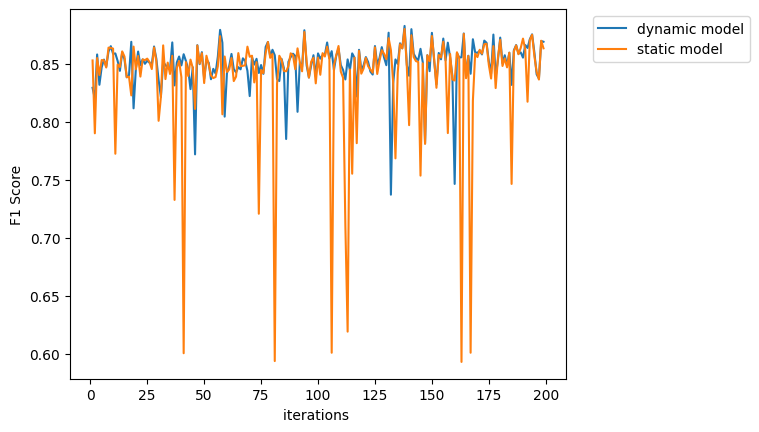

In [108]:
plt.plot(range(1, 200), Dynmaic_model_scores, label=f'dynamic model')
plt.plot(range(1, 200),static_model_scores, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")